# Posprocessing a run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.6

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.6


In [3]:
# import lenses
import jax
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt

from flox.util import key_chain
from flox.flow import Pipe
# from flox._src.flow.api import Inverted, Transform, Transformed, bind
import equinox as eqx

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import Data, DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import FlowSpecification, CouplingSpecification, ExperimentSpecification
# from rigid_flows.density import PositionPrior, RotationPrior
from rigid_flows.utils import jit_and_cleanup_cache, scanned_vmap

chain = key_chain(42)

2023-01-22 06:58:42.774565: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-22 06:58:42.774655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-22 06:58:42.774662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}

In [5]:
# logdir_path = 'jonas_logdir/tuna_N128_2023-01-21_15:01:34'
logdir_path = 'jonas_logdir/dragonfly_N128_less_2023-01-21_19:20:11'
stage = 0
epoch = 9
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f'{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx'


specs = ExperimentSpecification.load_from_file(specs_path)
# specs = lenses.bind(specs).model.flow.couplings.set(())

base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base)
target = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.target)
model = base.omm_model.model

data = Data.from_specs(specs.model.target, target.box)
flow = build_flow(next(chain), specs.model.auxiliary_shape, specs.model.flow)
flow = cast(
            Pipe[DataWithAuxiliary, RigidWithAuxiliary],
            eqx.tree_deserialise_leaves(
                pretrained_model_path, flow
            ),
        )

print(f'tot flow parameters: {count_params(flow):_}')

tot flow parameters: 11_240_576


In [6]:
reference_deltaF, reference_deltaF_std = None, None

if specs.model.base.temperature == specs.model.target.temperature:
    reference_deltaF, reference_deltaF_std = 0, 0
elif specs.model.base.num_molecules == 16:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        reference_deltaF, reference_deltaF_std = -664.56, 0.03
    elif specs.model.base.temperature == 100 and specs.model.target.temperature == 250:
        reference_deltaF, reference_deltaF_std = 664.56, 0.03
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        reference_deltaF, reference_deltaF_std = -1815.51, 0.15
    elif specs.model.base.temperature == 50 and specs.model.target.temperature == 250:
        reference_deltaF, reference_deltaF_std = 1815.51, 0.15
elif specs.model.base.num_molecules == 128:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        reference_deltaF, reference_deltaF_std = -5314.02, 10.0

reference_deltaF, reference_deltaF_std

(-5314.02, 10.0)

In [7]:
num_samples = 1_000
batch_size = 128

keys = jax.random.split(next(chain), num_samples)
base_tr = jax.vmap(base.sample)(keys)

mapped_tr = scanned_vmap(flow.inverse, batch_size)(base_tr.obj) #TODO add batch

keys = jax.random.split(next(chain), num_samples)
target_tr = jax.vmap(target.sample)(keys)

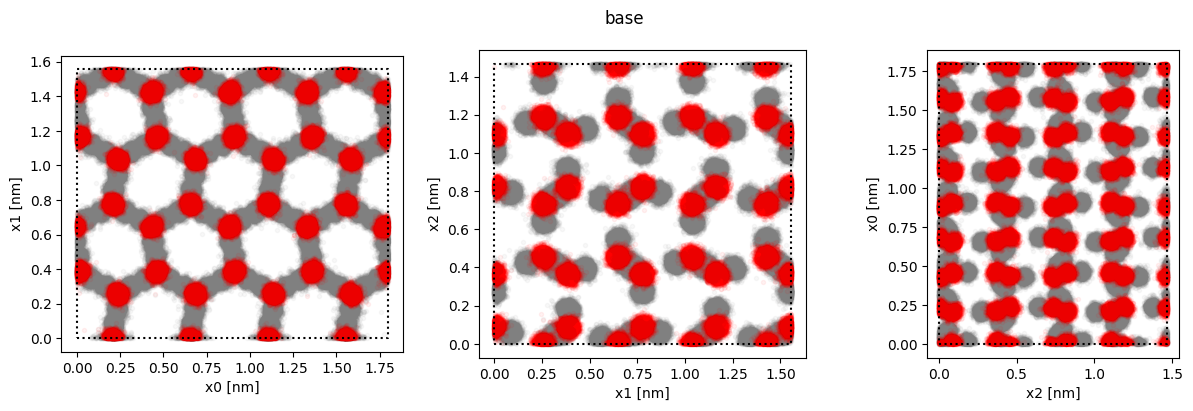

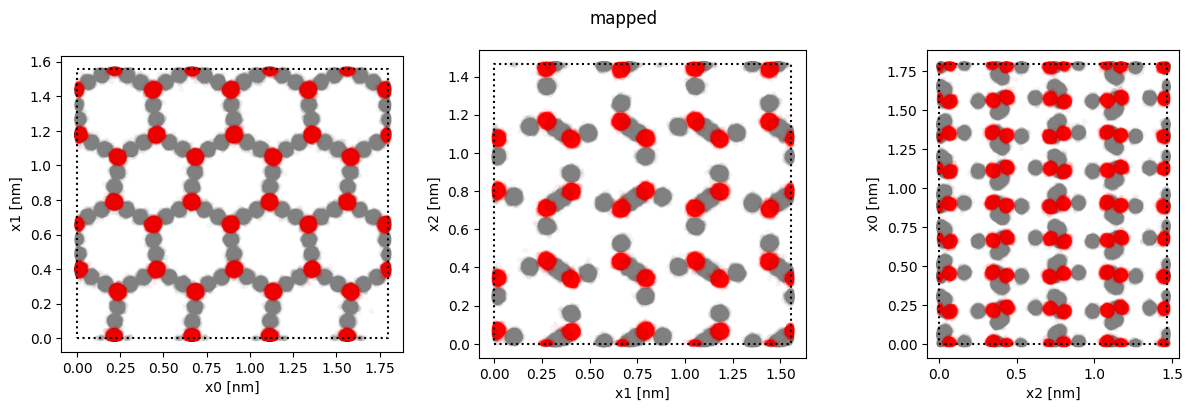

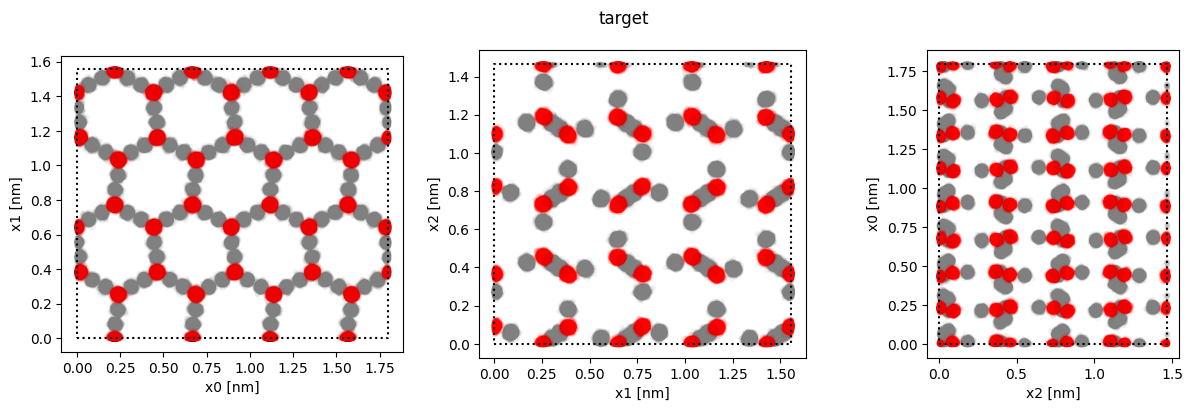

In [8]:
toPBC = True
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='base')
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='mapped')
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='target')


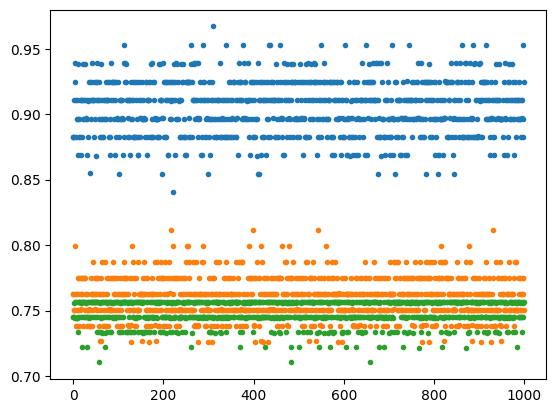

In [9]:
## closer look at the center of mass
com_pos = mapped_tr.obj.pos.mean(axis=(1,2))
plt.plot(com_pos, '.')
plt.show()

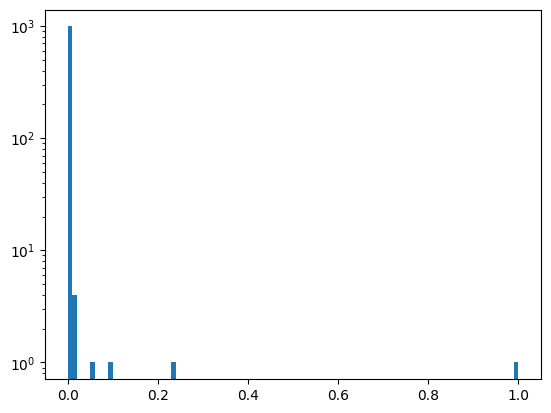

ESS = 2.05588  ->  0.21%


In [10]:
def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)

plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

In [11]:
ene_fn = jax.vmap(target.potential)
base_ene = ene_fn(base_tr.obj)
mapped_ene = ene_fn(mapped_tr.obj)
target_ene = ene_fn(target_tr.obj)

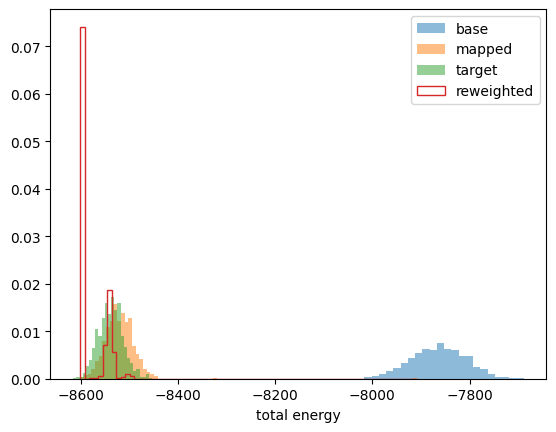

In [12]:
plt.hist(base_ene, **hist_kwargs, label='base')
plt.hist(mapped_ene, **hist_kwargs, label='mapped')
plt.hist(target_ene, **hist_kwargs, label='target')
plt.hist(mapped_ene, weights=np.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel('total energy')
plt.legend()
plt.show()

In [13]:
ene_label = 'omm'
scaling = 1
if ene_label == 'omm':
    scaling = target.omm_model.kbT
base_ene2 = target.compute_energies(base_tr.obj, True, True, True)[ene_label] * scaling
target_ene2 = target.compute_energies(target_tr.obj, True, True, True)[ene_label] * scaling
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, True, True)[ene_label] * scaling

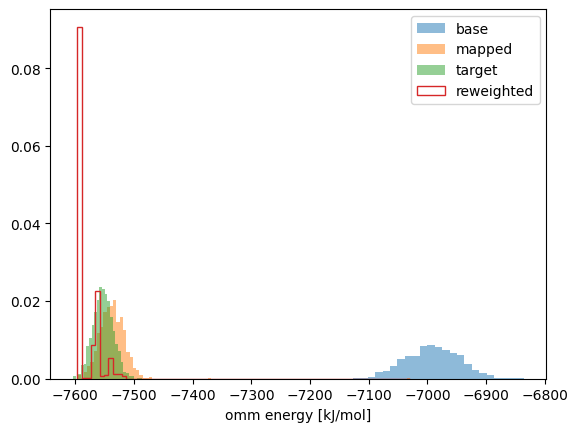

In [14]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.hist(mapped_ene2, weights=np.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel(ene_label + ' energy [kJ/mol]') #it's kJ/mol only for omm energies
plt.legend()
plt.show()

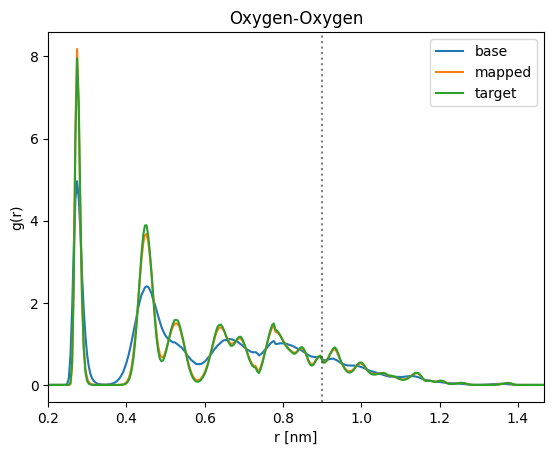

In [15]:
r_range = [0.2, np.diag(model.box).min()]
n_bins = 300
plt.title('Oxygen-Oxygen')
model.plot_rdf(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='base')
model.plot_rdf(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='mapped')
model.plot_rdf(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='target')
plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
plt.legend()
plt.show()

In [16]:
## TFEP
deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
print(f'Estimated deltaF from TFEP (below) = {deltaF:g}')
if reference_deltaF is not None:
    print(f'                  Reference deltaF = {reference_deltaF:g}')

Estimated deltaF from TFEP (below) = -5314.5
                  Reference deltaF = -5314.02


In [17]:
num_datapoints = specs.model.base.num_samples
if num_datapoints is None:
    selection = np.s_[:]
else:
    selection =  np.s_[-num_datapoints:]

def estimate_deltaF(key, num_samples, base, batch_size=128):
    keys = jax.random.split(key, num_samples)
    base_tr = jax.vmap(base.sample)(keys)
    mapped_tr = scanned_vmap(flow.inverse, batch_size)(base_tr.obj)
    logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)
    return (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()

eval_base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base, selection)
eval_base.data.pos.shape[0]

10000

In [18]:
estimate_from_training = False #this gives a biased estimate, always lower

from tqdm import trange

#FIXME: it's maybe better to use all MD points instead of random samples
iterations = 10
n_samples = 1000 

if estimate_from_training:
    deltaFs = np.zeros(iterations)
    for i in trange(iterations):
        deltaFs[i] = estimate_deltaF(next(chain), n_samples, base)
    print(f'deltaF = {deltaFs.mean():g} +/- {deltaFs.std():g}')

eval_deltaFs = np.zeros(iterations)
for i in trange(iterations):
    eval_deltaFs[i] = estimate_deltaF(next(chain), n_samples, eval_base)
eval_deltaFs.mean(), eval_deltaFs.std()
print(f'deltaF = {eval_deltaFs.mean():g} +/- {eval_deltaFs.std():g}')

100%|██████████| 10/10 [03:43<00:00, 22.37s/it]

deltaF = -5311.64 +/- 1.15072


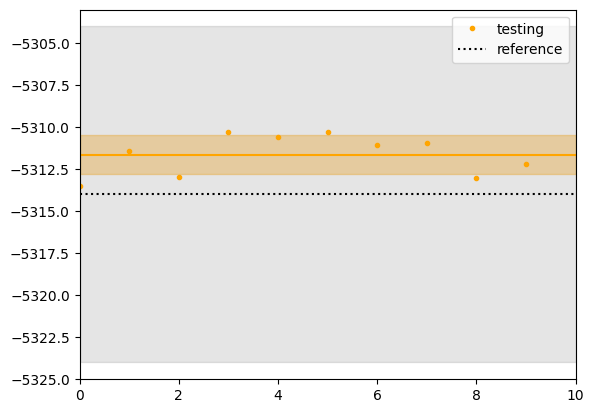

In [19]:
xlim = [0, len(eval_deltaFs)]
if estimate_from_training:
    plt.plot(deltaFs, '.', c='blue', label='training')
    x = 2 * [deltaFs.mean()]
    plt.fill_between(xlim, x-deltaFs.std(), x+deltaFs.std(), color='blue', alpha=0.3)
    plt.axhline(deltaFs.mean(), c='blue')
plt.plot(eval_deltaFs, '.', c='orange', label='testing')
x = 2 * [eval_deltaFs.mean()]
plt.fill_between(xlim, x-eval_deltaFs.std(), x+eval_deltaFs.std(), color='orange', alpha=0.3)
plt.axhline(eval_deltaFs.mean(), c='orange')
if reference_deltaF is not None:
    plt.axhline(reference_deltaF, c='k', ls=":", label='reference')
    x = np.array(2 * [reference_deltaF])
    plt.fill_between(xlim, x-reference_deltaF_std, x+reference_deltaF_std, color='k', alpha=0.1)
plt.xlim(xlim)
plt.legend()
plt.show()

In [20]:
df = estimate_deltaF(next(chain), iterations*n_samples, eval_base)
df

-5312.16259765625

epoch 5: deltaF = -5312.02 +/- 0.889795